Homework 4
---

In this homework assignment you will be tasked with implementing a K-means clustering and a Gaussian mixture model using Gibbs sampling. You may refer to the lecture slides on clustering for the high level overview of implementing these algorithms. For the case of the Gaussian mixture model, suppose our data generating process is:

$X_i \sim N(\mu_{z_i}, \sigma^2_0 I)$

$\mu_k \sim N(\mu_0, \tau^2_0)$

$z_i \sim \mbox{Categorical}(\pi)$

$\pi \sim \mbox{Dirichlet}(\alpha_0)$

You may fix the value of the hyperpriors $\sigma_0^2,\tau^2_0, \mu_0, \alpha_0$. Note that the likelihood for $X_i$ is a multivariate Gaussian distribution.

---

1.) Derive the posterior updates for the parameters $\mu_k, \pi, z_i$. For deriving the full conditional of $\mu_k$, two properties that may be useful are the properties of the conditional distribution of a m.v. Gaussian (https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions) and completing the square of a matrix (https://en.wikipedia.org/wiki/Completing_the_square#Matrix_case).

2.) Compare the Gibbs sampling algorithm using the posterior updates you wrote in Question 1 with the K-Means algorithm. Under what conditions is the K-Means algorithm a special case of the Gibbs sampler for a GMM?

3.) Now, implement the Gibbs sampler for the GMM and the K-Means algorithm. Test to see if your implementation works correctly by fitting the model by generating some synthetic data. You may use the function `sklearn.datasets.make_blobs' with the default setting to test this. One quantitative way to measure the performance per iteration to track the progress of your model is to calculate the log-likelihood of the data per iteration. If it improves on average, then you may be in the right direction (this is not mandatory, but it should help during the debugging process).

4.) Fit the data to the `sklearn.datasets.load_digits' handwritten data set. It may be helpful to rescale the data to have zero mean and unit variance. Try to plot the cluster centers, comment on the performance.




In [607]:
#1. Derive GMM updates
#2. Write K-Means algorithm
#3. Write GMM algorithm
#4. compare K means and GMM- when equivalent
#5 implement on synthetic data
#6. handwritten data

#code to debug code
# from IPython.core.debugger import set_traces
# import warnings
#use set trace to debug code

#import required libraries
import numpy as np
from scipy.stats import multivariate_normal

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
#Question 1
#Part 1, K-Means algorithm

class KMeans:
    def __init__(self, k=5, max_iters=100, verbose=True):
        self.k = k                                            #number of cluster centers
        self.max_iters = max_iters
        self.verbose = verbose                                #we generally use this to print something inside a class or function
    
    def fit(self, x):
        n,d = x.shape
        init_centers = np.random.choice(n, self.k, replace=False)      #randomly choose a list of k distinct indices from 0 to n-1
        mu = x[init_centers]                                           #initialize the cluster centers [k,d]
        for t in range(self.max_iters):
            distances = np.sum((mu[None,:,:] - x[:,None,:])**2, -1)     #compute the distance of every point from the cluster centers [n,k]
            membership = np.argmin(distances, axis=1)                        #find the cluster center each x is closest to  [n]
            mu_new = mu.copy()                                          
            for i in range(self.k):
                mu_new[i,:] = np.mean(x[membership==i], axis=0)              #compute the new cluster centers using the updated membership
            if np.allclose(mu_new, mu):
                if self.verbose:
                    print(f'converged after {t} iterations, cost {np.sum(np.min(distances,1))}')
                break
            mu = mu_new
        return mu, membership

In [692]:
#Question 1
#Part 2,GMM
# Set the seed value
np.random.seed(42)

#initiate the class GMM with the prior parameters
#condition alpha_null>=1
class GMM:
    def __init__(self, k=5,mu0=0,sigma0=1, tau0=1,pi=None,alpha0=2,max_iters=100,tol=1e-4,update_variance=False,mean_initializer='kmeans'):
        self.k=k
        self.alpha=alpha0
        self.max_iters = max_iters
        self.tol=tol
        self.mu0=mu0
        self.sigma0=sigma0
        self.tau= tau0
        self.pi=pi
        self.log_likelihood=[-np.inf]
        self.update_variance=update_variance
        self.mean_initializer=mean_initializer
    
    def fit(self, x):
        #initiate parameters of data fitted
        self.n=x.shape[0]
        self.d=x.shape[1]

        #used in expectation step

        #initialize the full conditional of ynk P(z|x,pi,mu,sigma0)
        full_cond_Z=np.zeros((self.n,self.k))

        #used in maximization step
        #permute data and split data into k partitions
        permute_split_x=np.array_split(np.random.permutation(x),self.k)
        # print(permute_split_x)

        #initialize the mu parameter by using the data in each set to set up the cluster means
        #set up empty array to hold zeros first
        self.mu=np.zeros((self.k,self.d))
        #if mean initializer is random, split data into k partitions, use means in each partition to intialize means
        if self.mean_initializer=="random":
            for k in range(self.k):
                self.mu[k]=np.mean(permute_split_x[k],axis=0)
        #if mean initializer is kmeans, use kmeans to intialize means
        elif self.mean_initializer=="kmeans":
            kmeans=KMeans(k=self.k,max_iters=20).fit(x)
            predicted_cluster_mean=kmeans[0]
            self.mu=predicted_cluster_mean
        
        #initialize the shared sigma parameter by calculating variance across rows and columns of dataset
        #set up sigma array with sigma0 value, updated in the iteration part below
        self.sigma_sq=np.full(self.k,self.sigma0**2)
        for k in range(self.k):
            self.sigma_sq[k]=np.var(permute_split_x[k],axis=(0,1))
        #add in constant to prevent blow up
        self.sigma_sq=self.sigma_sq+0.01
        # print(self.sigma_sq)
            
        #initialize pi, posterior of weights P(pi|zn)
        self.pi=np.full(self.k,1/self.k)
        
        #check initialization
        # print(self.pi,self.mu,self.sigma_sq,"a")

        for i in range(self.max_iters):
            if i!=0 and ((self.log_likelihood[-1]-self.log_likelihood[-2])<self.tol):
                break
            #step 1
            #run posterior update for full conditional of ynk P(z|x,pi,mu,sigma0)
            #ynk=pi_k*N(xn|mu_k,sigma)/sum(pi_k*N(xn|mu_k,sigma)) across k
            for k in range(self.k):
                # print(multivariate_normal.pdf(x,mean=self.mu[k],cov=self.sigma_sq[k]))
                #Probably put in section to add in constant to prevent blow up
                full_cond_Z[:,k]=self.pi[k]*multivariate_normal.pdf(x,mean=self.mu[k],cov=self.sigma_sq[k])
            # print(full_cond_Z)
            self.full_cond_Z=full_cond_Z/np.sum(full_cond_Z,axis=1)[:,np.newaxis]
            # print(self.full_cond_Z)

            #step 2
            #hard assignment of data points to clusters zi=argmax(ynk) across k
            self.z=np.argmax(full_cond_Z,axis=1)
            #indicator matrix of znk, 1 if zn=k, 0 if zn!=k, dim(n,k)
            self.z_ind=(self.z[:,np.newaxis]==np.arange(0,self.k+1)).astype(int)
            # print(self.z)

            #step 3
            #update posterior mean of class k, mu_k
            for k in range(self.k):
                k_indices=self.z_ind[:,k]
                #change to sigma
                mean_denom=np.sum(k_indices)/self.sigma_sq[k]+1/self.tau**2
                self.mu[k]=(np.sum(k_indices*x.T,axis=1)/self.sigma_sq[k] +self.mu0/self.tau**2)/mean_denom
            # print(self.mu)

            #step 4
            #update sigma for class k, sigma_k shared by all dimensions d
            if self.update_variance==True:
                #use matrix
                for k in range(self.k):
                    k_indices=self.z_ind[:,k]
                    N_k=np.sum(k_indices)
                    # print(k_indices)
                    # print(np.sum((x-self.mu[k])*(x-self.mu[k]),axis=1))
                    sum_error_k=k_indices@np.sum((x-self.mu[k])*(x-self.mu[k]),axis=1)
                    #this part blow up
                    self.sigma_sq[k]=(sum_error_k+0.01)/(N_k*self.d+0.01)
                    # print(self.sigma_sq)

            #step 5 
            #update posterior probability of class k, pi_k
            for k in range(self.k):
                k_indices=self.z_ind[:,k]
                N_k=np.sum(k_indices)
                self.pi[k]=(N_k+self.alpha-1)/(self.n+self.k*(self.alpha-1))
            # print(self.pi)

            #step 6
            #calculate log-likelihood
            total_likelihood=0
            for n in range(self.n):
                for k in range(self.k):
                    log_likelihood_k=self.full_cond_Z[n,k]*(np.log(self.pi[k])+np.log(multivariate_normal.pdf(x[n],mean=self.mu[k],cov=self.sigma_sq[k])))
                    total_likelihood+=log_likelihood_k
            self.log_likelihood.append(total_likelihood)
            # print(total_likelihood)
        
        #check whether GMM should be rerun
        classification_check=self.predict(x)
        if np.all(classification_check==classification_check[0]):
            print("Warning: all data classified to one class")
            print(f"Classification: {classification_check}")
        elif np.bincount(classification_check).shape[0]!=self.k or np.any(np.bincount(classification_check)==0):
            print("Warning: some classes do not have any points assigned to them")
            print(f"Classification: {classification_check}")
        return self
    
    def predict(self, x):
        #calculate the joint probability of x and z
        joint_prob=np.zeros((x.shape[0],self.k))
        #calculate the joint probability of x and z
        for k in range(self.k):
            joint_prob[:,k]=self.pi[k]*multivariate_normal.pdf(x,mean=self.mu[k],cov=self.sigma_sq[k])
        #assign x to the class with the highest probability
        predictions=np.argmax(joint_prob,axis=1)
        return predictions

In [706]:
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
# X = np.array([[1, 2,3], [1, 4,3], [1, 0,0], [10, 2,1], [10, 4,1], [10, 0,2]])
gmm=GMM(k=2,max_iters=10,alpha0=1,mu0=np.array([1,1]),mean_initializer="random")
gmm.fit(X)
# print(gmm.full_cond_Z)
# print(np.argmax(gmm.full_cond_Z,axis=1))
# print(gmm.mu)
# gmm.sigma_sq
gmm.predict(X)

array([0, 0, 0, 1, 1, 1], dtype=int64)

False

In [620]:
# from sklearn.mixture import BayesianGaussianMixture
# X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
# bgm = BayesianGaussianMixture(n_components=2, random_state=0,covariance_type='tied',weight_concentration_prior_type='dirichlet_distribution',weight_concentration_prior=2.1).fit(X)
# bgm.means_

# # gm = GaussianMixture(n_components=3, random_state=0,covariance_type='tied').fit(data)
# # gm.means_

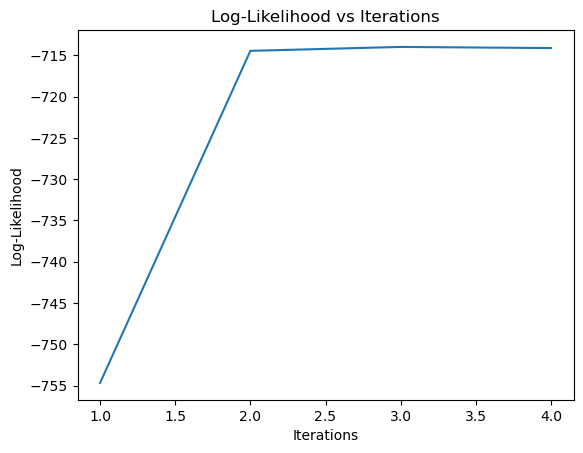

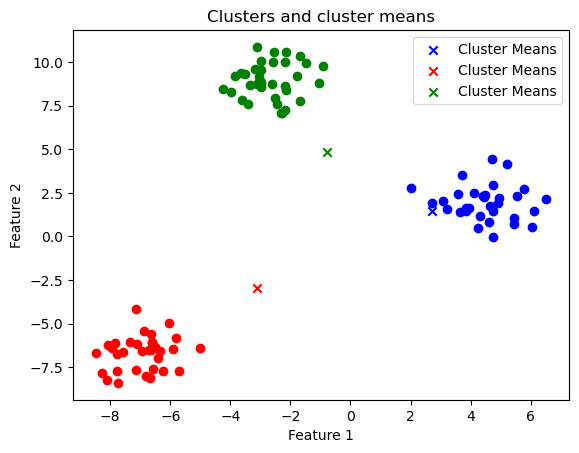

In [707]:
#Question 3
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, centers=3,n_features=2, cluster_std=1, random_state=42)

gmm_1=GMM(k=3,max_iters=100,alpha0=2,mu0=np.array([1,1]),mean_initializer="random")
gmm_1.fit(X)
predicted_label=gmm_1.predict(X)

#plot loglikelihood
plt.plot(range(len(gmm_1.log_likelihood)),gmm_1.log_likelihood)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Iterations')
plt.show()

#plot output
#cluster label=0
X_filtered0=X[predicted_label==0]
plt.scatter(X_filtered0[:,0],X_filtered0[:,1],color='blue')
#cluster label=1
X_filtered1=X[predicted_label==1]
plt.scatter(X_filtered1[:,0],X_filtered1[:,1],color='red')
#cluster label=2
X_filtered2=X[predicted_label==2]
plt.scatter(X_filtered2[:,0],X_filtered2[:,1],color='green')

#cluster means
#cluster 0
plt.scatter(gmm_1.mu[0,0],gmm_1.mu[0,1],color="blue",marker="x",label="Cluster Means")
#cluster 1
plt.scatter(gmm_1.mu[1,0],gmm_1.mu[1,1],color="red",marker="x",label="Cluster Means")
#cluster 2
plt.scatter(gmm_1.mu[2,0],gmm_1.mu[2,1],color="green",marker="x",label="Cluster Means")


plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Clusters and cluster means")
plt.legend()
plt.show()

converged after 2 iterations, cost 171.91098459057724


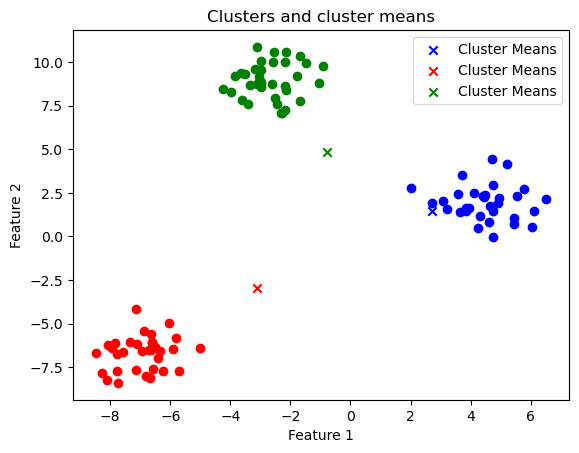

In [708]:
#Question 3 part 2

#use Kmeans to fit on data and find cluster means
X, y = make_blobs(n_samples=100, centers=3,n_features=2, cluster_std=1, random_state=42)
kmeans_1=KMeans(k=3,max_iters=100)
cluster_centre,predicted_label=kmeans_1.fit(X)

#plot output
#cluster label=0
X_filtered0=X[predicted_label==0]
plt.scatter(X_filtered0[:,0],X_filtered0[:,1],color='blue')
#cluster label=1
X_filtered1=X[predicted_label==1]
plt.scatter(X_filtered1[:,0],X_filtered1[:,1],color='red')
#cluster label=2
X_filtered2=X[predicted_label==2]
plt.scatter(X_filtered2[:,0],X_filtered2[:,1],color='green')

#cluster means
#cluster 0
plt.scatter(gmm_1.mu[0,0],gmm_1.mu[0,1],color="blue",marker="x",label="Cluster Means")
#cluster 1
plt.scatter(gmm_1.mu[1,0],gmm_1.mu[1,1],color="red",marker="x",label="Cluster Means")
#cluster 2
plt.scatter(gmm_1.mu[2,0],gmm_1.mu[2,1],color="green",marker="x",label="Cluster Means")


plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Clusters and cluster means")
plt.legend()
plt.show()

In [724]:
#Question 4
#import data from scikit-learn library
from sklearn.datasets import load_digits

#save the data into an array
digits=load_digits()
data=digits["data"]

# #normalize the data by subtracting mean of that column and dividing by standard deviation
# data_mean=np.mean(data,axis=0)
# #may have numerical issues if  variance=0 for column
# data_std=np.std(data,axis=0)+1e-6
# std_data=(data-data_mean)/data_std

#fit model to data
gmm_digits=GMM(k=10,max_iters=100,alpha0=2,mu0=np.ones(64),mean_initializer="kmeans")
gmm_digits.fit(data)

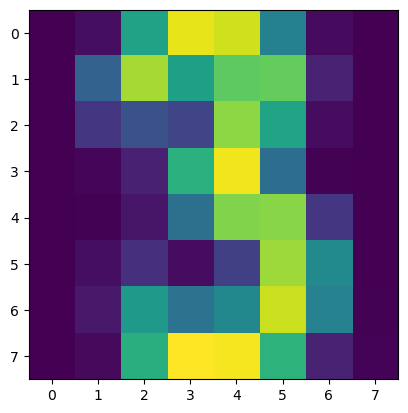

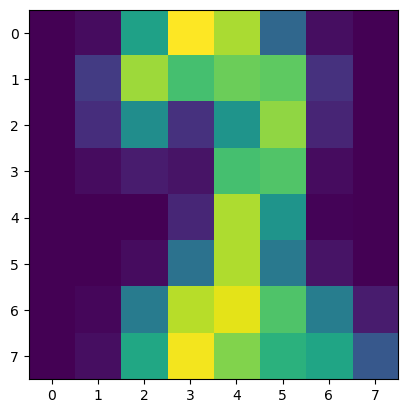

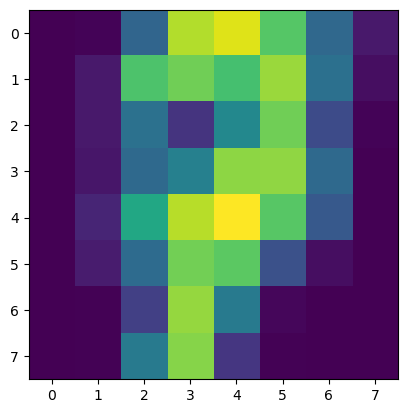

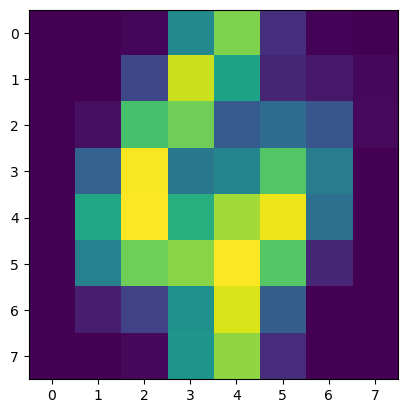

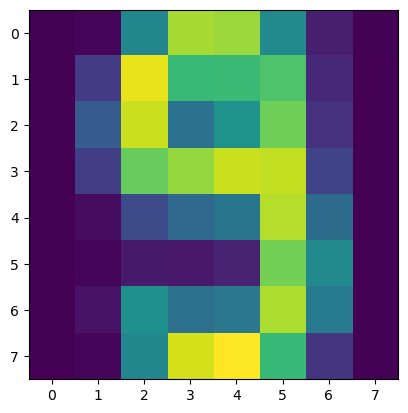

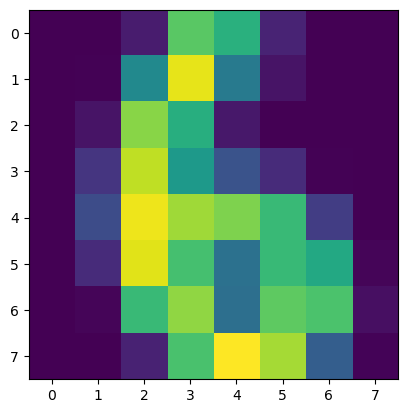

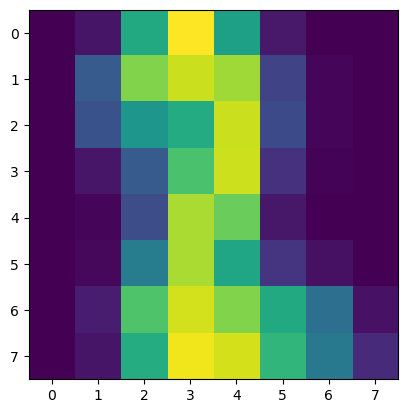

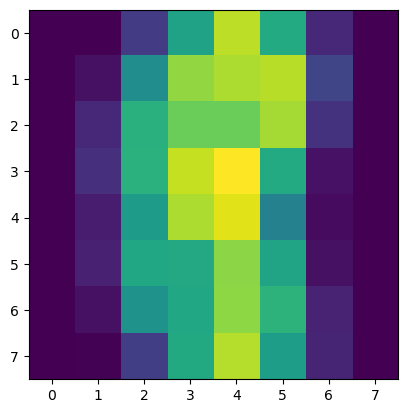

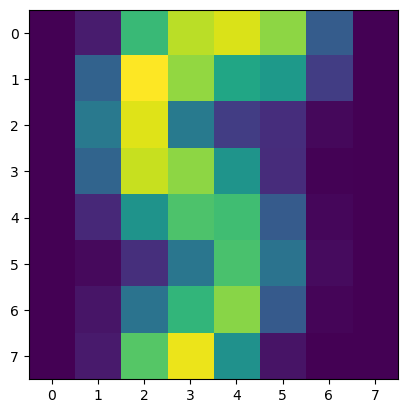

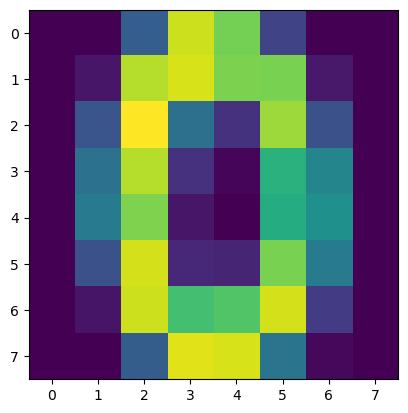

In [725]:
#Question 4 continued,GMM
## In this part we use a heat map to observe the cluster centres
cluster_centre=gmm_digits.mu
for i in range(10):
    cntr = cluster_centre[i].reshape(8,8)
    fig, ax =  plt.subplots()
    im = ax.imshow(cntr)
    plt.show()

converged after 17 iterations, cost 1209956.2077688677


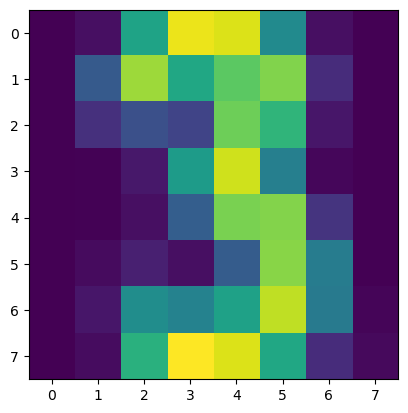

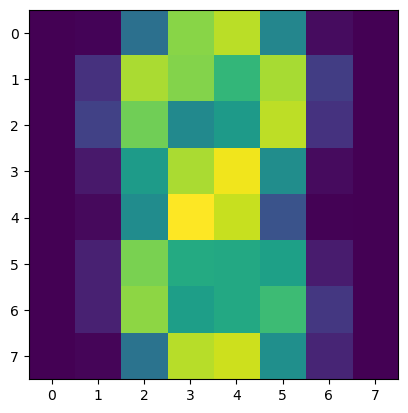

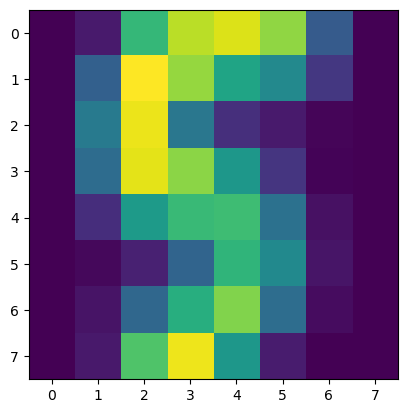

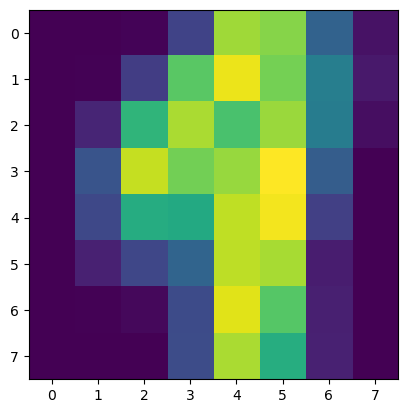

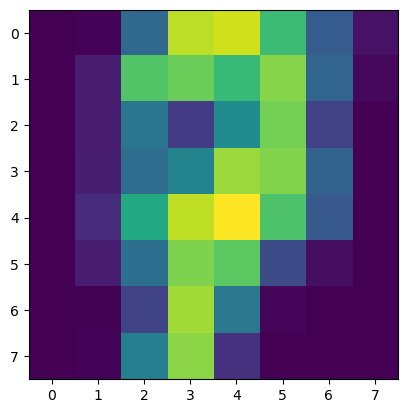

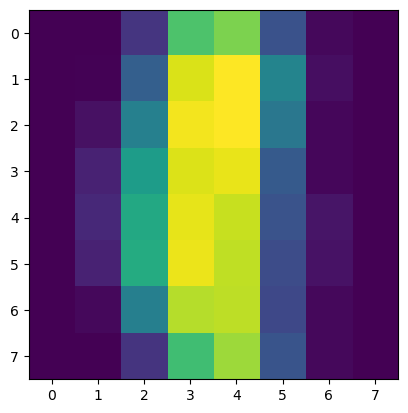

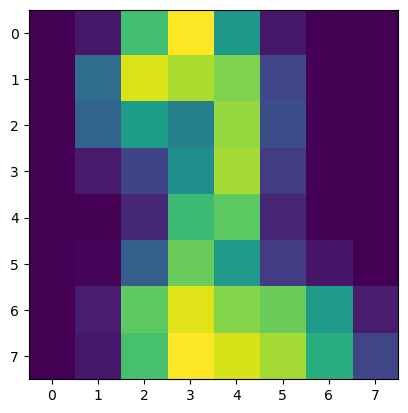

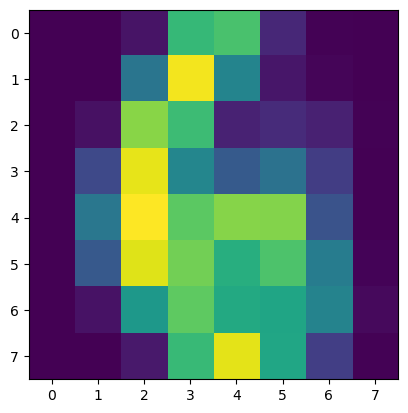

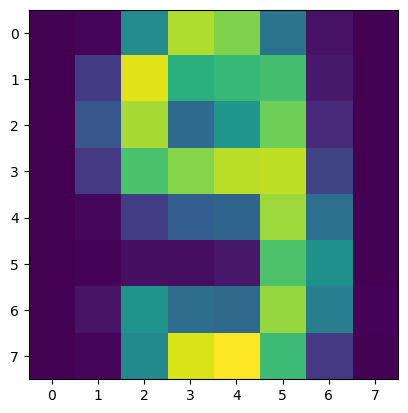

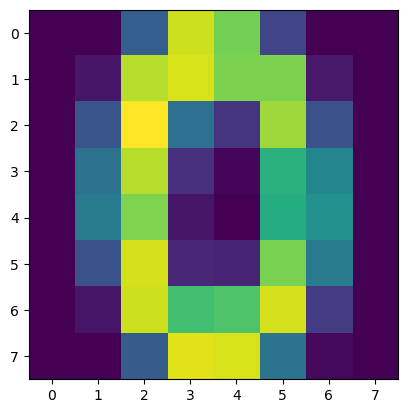

In [722]:
#Question 4 continued
#fit model to data
kmeans_digits=KMeans(k=10,max_iters=1000)

## In this part we use a heat map to observe the cluster centres
cluster_centre=kmeans_digits.fit(data)[0]
for i in range(10):
    cntr = cluster_centre[i].reshape(8,8)
    fig, ax =  plt.subplots()
    im = ax.imshow(cntr)
    plt.show()

In [716]:
cluster_centre

(array([[0.00000000e+00, 2.22222222e-02, 4.21111111e+00, 1.31277778e+01,
         1.12833333e+01, 2.95000000e+00, 3.33333333e-02, 0.00000000e+00,
         0.00000000e+00, 8.83333333e-01, 1.26388889e+01, 1.33722222e+01,
         1.13777778e+01, 1.13777778e+01, 9.61111111e-01, 0.00000000e+00,
         0.00000000e+00, 3.75555556e+00, 1.42111111e+01, 5.23333333e+00,
         2.09444444e+00, 1.21388889e+01, 3.53333333e+00, 0.00000000e+00,
         0.00000000e+00, 5.29444444e+00, 1.26444444e+01, 2.02222222e+00,
         2.61111111e-01, 9.11666667e+00, 6.44444444e+00, 0.00000000e+00,
         0.00000000e+00, 5.85555556e+00, 1.15111111e+01, 9.50000000e-01,
         1.22222222e-01, 8.82777778e+00, 7.11111111e+00, 0.00000000e+00,
         0.00000000e+00, 3.49444444e+00, 1.32388889e+01, 1.72777778e+00,
         1.50000000e+00, 1.13611111e+01, 5.83333333e+00, 0.00000000e+00,
         0.00000000e+00, 8.00000000e-01, 1.30555556e+01, 9.98888889e+00,
         1.03333333e+01, 1.33111111e+01, 2.46666667